# Описание

Решить задачу классификации при помощи обучения модели логистической регрессии. Качество модели оценивается путем подсчета метрик TPR, FPR и построения графиков ROC-кривой, Precision-Recall. 

## Импорт библиотек

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import plotly.io as pio
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# установка отображения графиков в Jupyter Notebook
pio.renderers.default = "notebook"

# константы
RANDOM_STATE = 42

## Загрзузка и анализ данных

In [2]:
# Загрузка данных
data = pd.read_csv("../data/athletes.csv")

In [3]:
# Просмотр 5 случайных записей датасета
data.sample(5)

,id,name,nationality,sex,dob,height,weight,sport,gold,silver,bronze
7283,965246251,Md Fakhri Ismail,BRU,male,3/6/91,1.60,62.0,athletics,0,0,0
7182,427248664,Matteo Galvan,ITA,male,8/24/88,1.82,78.0,athletics,0,0,0
10190,835906599,Sven Maresch,GER,male,1/19/87,1.73,83.0,judo,0,0,0
7621,355342299,Misha Aloian,RUS,male,8/23/88,1.65,NaN,boxing,0,1,0
4172,743741137,Hugo Barrette,CAN,male,7/4/91,1.75,90.0,cycling,0,0,0


In [4]:
# Просмотр информации о датасете
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11538 entries, 0 to 11537
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           11538 non-null  int64  
 1   name         11538 non-null  object 
 2   nationality  11538 non-null  object 
 3   sex          11538 non-null  object 
 4   dob          11537 non-null  object 
 5   height       11208 non-null  float64
 6   weight       10879 non-null  float64
 7   sport        11538 non-null  object 
 8   gold         11538 non-null  int64  
 9   silver       11538 non-null  int64  
 10  bronze       11538 non-null  int64  
dtypes: float64(2), int64(4), object(5)
memory usage: 991.7+ KB


In [5]:
# Проверка наличия дубликатов
data.duplicated().sum()

0

In [6]:
# Проверка наличия пропущенных значений
data.isnull().sum()

id               0
name             0
nationality      0
sex              0
dob              1
height         330
weight         659
sport            0
gold             0
silver           0
bronze           0
dtype: int64

## Предобработка данных

In [7]:
# Удаление строк с пропущенными данными в 'height','weight' и 'dob'
data = data.dropna(subset=["height", "weight", "dob"])

In [8]:
# Кодирование категориальных переменных
le = LabelEncoder()
data["sex"] = le.fit_transform(data["sex"])

In [9]:
# Выбор признаков и целевой переменной
X = data[["height", "weight", "gold", "silver", "bronze"]]
y = data["sex"]

In [10]:
# Разделение данных на обучающие и тестовые выборки
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE
)

## Обучение модели и получение предсказаний

In [11]:
# Обучение модели логистической регрессии
model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

In [12]:
# Получение предсказаний вероятностей
probabilities = model.predict_proba(X_test)[:, 1]

## Построение ROC-кривой и вычисление ROC-AUC метрики

In [13]:
# Вычисление ROC-кривой
fpr, tpr, thresholds = roc_curve(y_test, probabilities)

# Вычисление ROC-AUC метрики
roc_auc = roc_auc_score(y_test, probabilities)
print(f"ROC AUC Score: {roc_auc:.2f}")

ROC AUC Score: 0.85


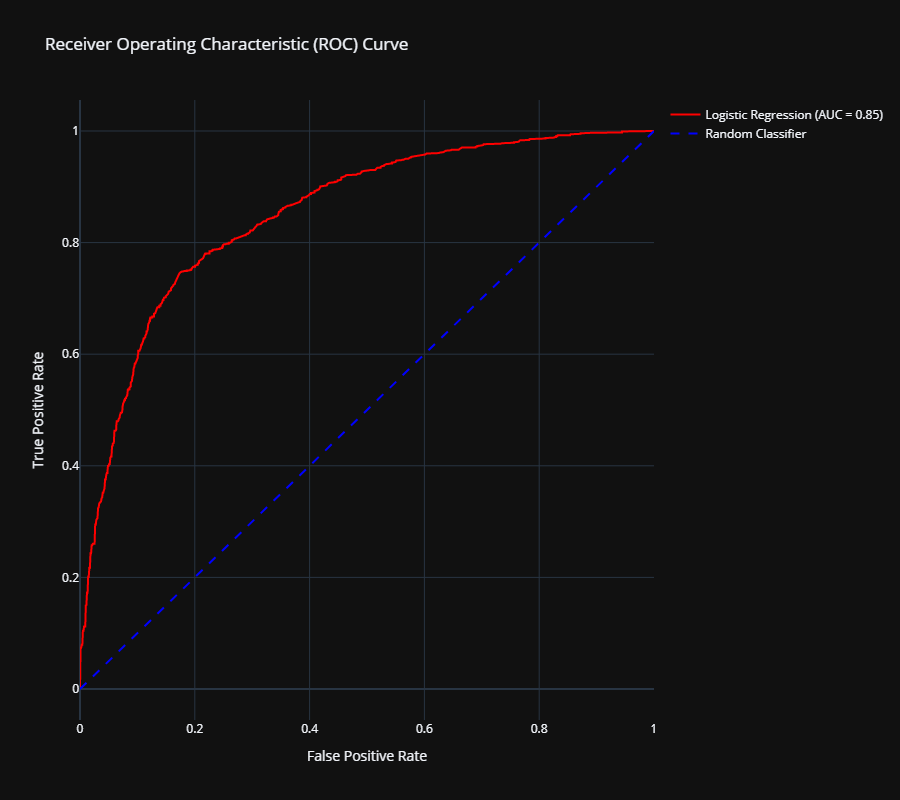

In [14]:
# Построение ROC-кривой с использованием Plotly
fig = go.Figure()

fig.add_trace(
    go.Scatter(
        x=fpr,
        y=tpr,
        mode="lines",
        name=f"Logistic Regression (AUC = {roc_auc:.2f})",
        line=dict(color="red"),
    )
)
fig.add_trace(
    go.Scatter(
        x=[0, 1],
        y=[0, 1],
        mode="lines",
        name="Random Classifier",
        line=dict(color="blue", dash="dash"),
    )
)

fig.update_layout(
    title="Receiver Operating Characteristic (ROC) Curve",
    xaxis_title="False Positive Rate",
    yaxis_title="True Positive Rate",
    showlegend=True,
    height=800,
    width=900,
    template="plotly_dark",
)

fig.show("png")

## Ручное вычисление TPR и FPR, построение ROC-кривой вручную

In [15]:
# Вручную вычисляем метрики TPR и FPR
thresholds_manual = np.arange(0, 1.1, 0.1)
tprs_manual, fprs_manual = [], []

for threshold in thresholds_manual:
    y_pred = (probabilities >= threshold).astype(int)
    tp = np.sum((y_pred == 1) & (y_test == 1))
    tn = np.sum((y_pred == 0) & (y_test == 0))
    fp = np.sum((y_pred == 1) & (y_test == 0))
    fn = np.sum((y_pred == 0) & (y_test == 1))

    tpr_manual = tp / (tp + fn)
    fpr_manual = fp / (fp + tn)

    tprs_manual.append(tpr_manual)
    fprs_manual.append(fpr_manual)

In [16]:
roc_auc_manual = np.trapz(tprs_manual, fprs_manual)

print(f"ROC AUC Score (Manual): {roc_auc_manual:.2f}")

ROC AUC Score (Manual): -0.85


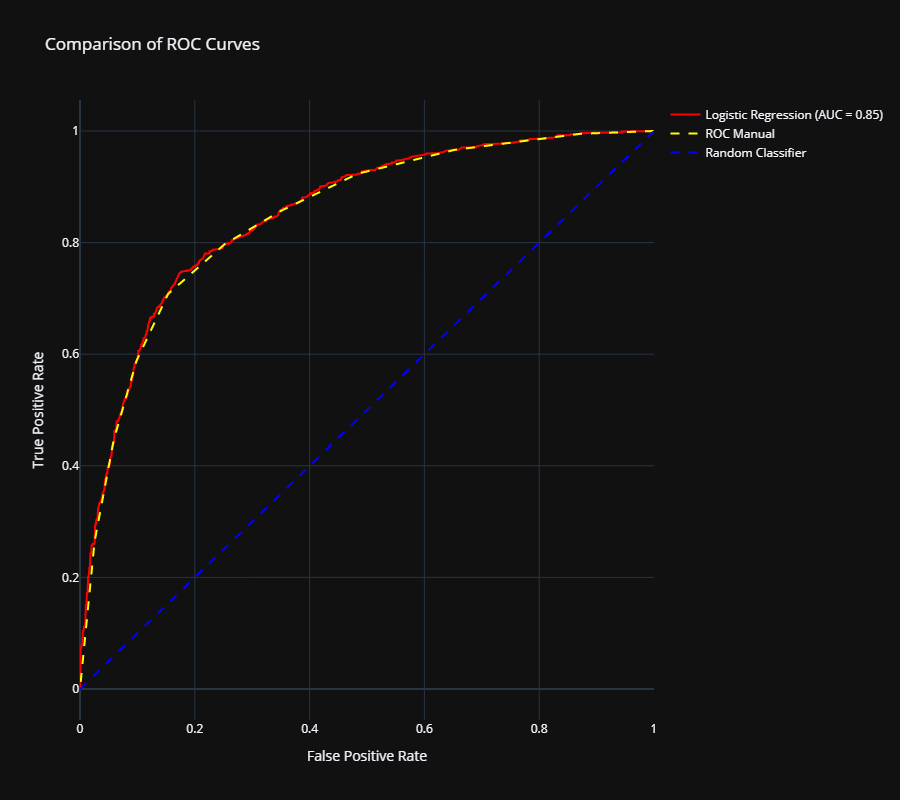

In [17]:
# Построение графиков с использованием Plotly
fig = go.Figure()

# ROC-кривая с использованием Sklearn
fig.add_trace(
    go.Scatter(
        x=fpr,
        y=tpr,
        mode="lines",
        name=f"Logistic Regression (AUC = {roc_auc:.2f})",
        line=dict(color="red"),
    )
)

# ROC-кривая, посчитанная вручную
fig.add_trace(
    go.Scatter(
        x=fprs_manual,
        y=tprs_manual,
        mode="lines",
        name="ROC Manual",
        line=dict(color="yellow", dash="dash"),
    )
)

# Диагональ случайного классификатора
fig.add_trace(
    go.Scatter(
        x=[0, 1],
        y=[0, 1],
        mode="lines",
        name="Random Classifier",
        line=dict(color="blue", dash="dash"),
    )
)

# Обновление параметров графика
fig.update_layout(
    title="Comparison of ROC Curves",
    xaxis_title="False Positive Rate",
    yaxis_title="True Positive Rate",
    showlegend=True,
    height=800,
    width=900,
    template="plotly_dark",
)

fig.show("png")

## Вычисление Precision-Recall кривой

In [18]:
precisions, recalls, _ = precision_recall_curve(y_test, probabilities)

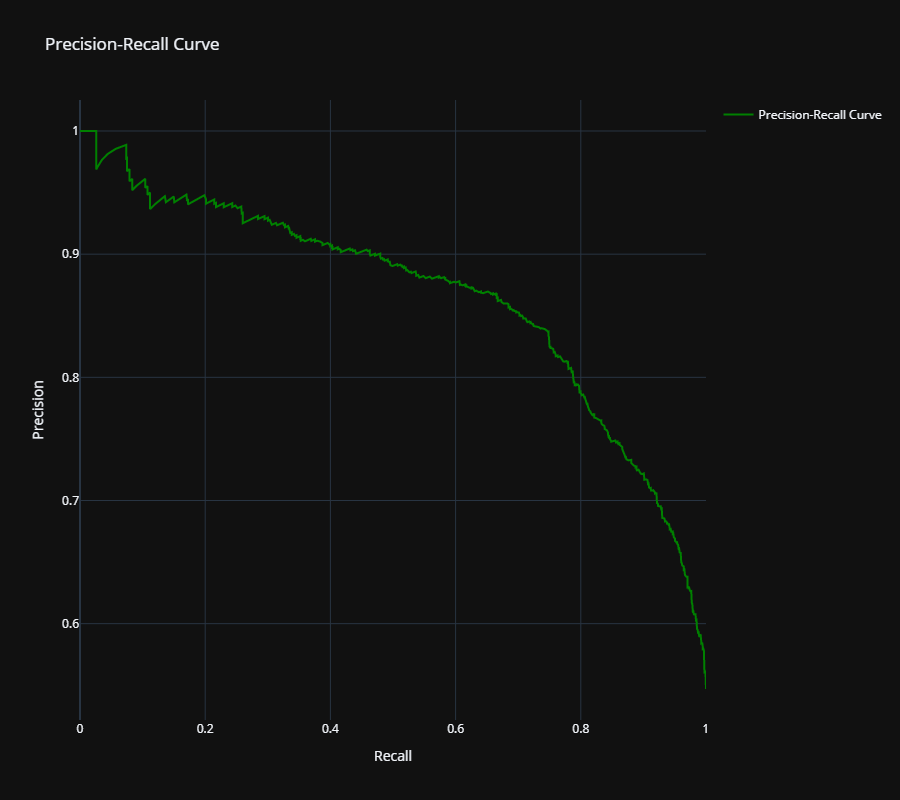

In [19]:
fig_pr = go.Figure()

fig_pr.add_trace(
    go.Scatter(
        x=recalls,
        y=precisions,
        mode="lines",
        name="Precision-Recall Curve",
        line=dict(color="green"),
    )
)

fig_pr.update_layout(
    title="Precision-Recall Curve",
    xaxis_title="Recall",
    yaxis_title="Precision",
    showlegend=True,
    height=800,
    width=900,
    template="plotly_dark",
)

fig_pr.show("png")

# Вывод

**Качество модели:**
Анализ ROC и Precision-Recall кривых позволяет сделать вывод о том, что модель обладает хорошим качеством. Значение ROC-AUC в обоих случаях (функция sklearn и вручную) высокое, что говорит о высокой точности классификации.

**Проверка корректности:** 
Ручное вычисление метрик совпадает с использованием библиотеки sklearn, что подтверждает корректность вычислений.

**Вопрос о ROC-кривой:**
Теоретически, ROC-кривая может проходить ниже диагонали, если классификатор работает хуже случайного угадывания, но это редко встречается на практике.